In [1]:
from lightgbm import LGBMRegressor
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.compose import TransformedTargetRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer
from IPython.display import display_html
from sklearn.utils import estimator_html_repr

from dbpedia_common import DataFrameRepository, get_single_stratified_split
from anomalies_analyser import compare_population_with_web
from models import get_lxgb_pipeline, ModelEvaluator

%matplotlib inline
train_df = DataFrameRepository(version='last').get()

In [6]:
display_html(estimator_html_repr(get_lxgb_pipeline()), raw=True)

Pipeline Pipeline(steps=[('calculated_pop', CalculatedPopTransformer()),
 ('categorical_transformer',
 Pipeline(steps=[('set_as_category',
 FunctionTransformer(func= .set_as_category at 0x7f8113bf65f0>))])),
 ('rename_columns',
 Pipeline(steps=[('rename_columns',
 FunctionTransformer(func= .rename_cols at 0x7f8113bf6a70>))])),
 ('model',
 LGBMRegressor(bagging_freq=20, cat_smooth=1,
 feature_fraction=0.4, learning_rate=0.03,
 max_depth=7, n_estimators=1500, num_leaves=20,
 reg_alpha=0.8))]) CalculatedPopTransformer CalculatedPopTransformer() categorical_transformer: Pipeline Pipeline(steps=[('set_as_category',
 FunctionTransformer(func= .set_as_category at 0x7f8113bf65f0>))]) FunctionTransformer FunctionTransformer(func= .set_as_category at 0x7f8113bf65f0>) rename_columns: Pipeline Pipeline(steps=[('rename_columns',
 FunctionTransformer(func= .rename_cols at 0x7f8113bf6a70>))]) FunctionTransformer FunctionTransformer(func= .rename_cols at 0x7f8113bf6a70>) LGBMRegressor LGBMRegressor(bagging_freq=20, cat_smooth=1, feature_fraction=0.4,
 learning_rate=0.03, max_depth=7, n_estimators=1500, num_leaves=20,
 reg_alpha=0.8)

********************
Test RMSLE: 0.26711634954959756
Test RMSE: 267592.805297454
********************
Train RMSLE: 0.24113254602222284
Train RMSE: 206033.14438055066


,pretty_subject,log_diff,log_target,log_predicted,target,predicted,diff,subject
34796,Tiyeglow>,-1.679,5.978,4.299,950000.000,19889.932,-930110.068,<http://dbpedia.org/resource/Tiyeglow>
21842,Merkezefendi>,-1.625,5.420,3.794,262825.000,6225.856,-256599.144,<http://dbpedia.org/resource/Merkezefendi>
29648,Río_Campo>,1.523,3.043,4.566,1105.000,36827.137,35722.137,<http://dbpedia.org/resource/Río_Campo>
18243,Kungsholmen_(borough)>,-1.457,4.833,3.375,68016.000,2373.666,-65642.334,<http://dbpedia.org/resource/Kungsholmen_(boro...
23970,New_Delhi>,1.378,5.411,6.789,257803.000,6157774.567,5899971.567,<http://dbpedia.org/resource/New_Delhi>
...,...,...,...,...,...,...,...,...
32034,Sitovo_Municipality>,-0.000,3.764,3.764,5810.000,5809.397,-0.603,<http://dbpedia.org/resource/Sitovo_Municipality>
22577,"Montague,_Massachusetts>",-0.000,3.926,3.926,8437.000,8436.623,-0.377,"<http://dbpedia.org/resource/Montague,_Massach..."
19158,"Lawrenceville,_Illinois>",0.000,3.638,3.638,4348.000,4348.188,0.188,"<http://dbpedia.org/resource/Lawrenceville,_Il..."
31647,"Sheridan,_Wyoming>",-0.000,4.242,4.242,17444.000,17443.806,-0.194,"<http://dbpedia.org/resource/Sheridan,_Wyoming>"


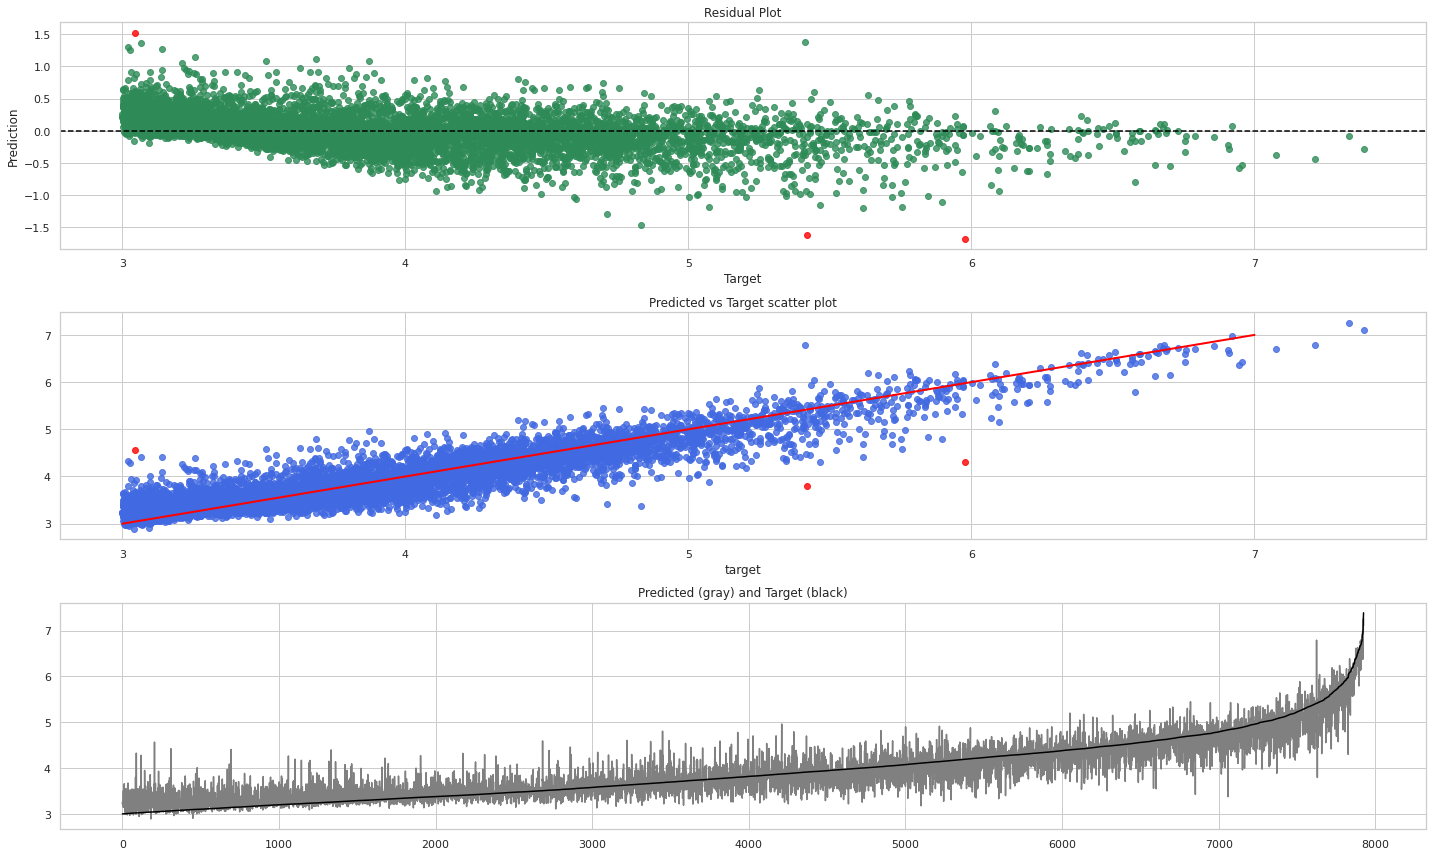

In [4]:
train_index, test_index = get_single_stratified_split(train_df)

X = train_df.drop(columns=['subject', 'target'])
y = np.log10(train_df.target)


X_train, y_train = X.loc[train_index], y.loc[train_index]
y_test = y.loc[test_index].sort_values()
X_test = X.loc[test_index].reindex(y_test.index)


model = TransformedTargetRegressor(regressor=get_lxgb_pipeline(), transformer=MinMaxScaler())
model.fit(X_train, y_train)
evaluator = ModelEvaluator(model, X_test, y_test, X_train, y_train)

test_pred, train_pred = evaluator.evaluate_model(eval_r2_score=False)
evaluator.plot_results()
error_analysis_df = evaluator.get_error_analysis(train_df)
error_analysis_df

In [5]:
compare_population_with_web(error_analysis_df, limit=10).head(10)

0 Errors found while parsing wikipedia webpage. Make a manual check for: []
There are 0 suspicious subjects! Check if found values are real and fix the records


,pretty_subject,error,expected_value,found_value,relative_log_diff,message,wiki_link,subject
0,Tiyeglow,False,950000.000,950000,0.000,,https://en.wikipedia.org/wiki/Tiyeglow,<http://dbpedia.org/resource/Tiyeglow>
1,Merkezefendi,False,262825.000,262825,0.000,,https://en.wikipedia.org/wiki/Merkezefendi,<http://dbpedia.org/resource/Merkezefendi>
2,Río_Campo,False,1105.000,1105,0.000,,https://en.wikipedia.org/wiki/R%C3%ADo_Campo,<http://dbpedia.org/resource/Río_Campo>
3,Kungsholmen_(borough),False,68016.000,68016,0.000,,https://en.wikipedia.org/wiki/Kungsholmen_%28b...,<http://dbpedia.org/resource/Kungsholmen_(boro...
4,New_Delhi,False,257803.000,257803,0.000,,https://en.wikipedia.org/wiki/New_Delhi,<http://dbpedia.org/resource/New_Delhi>
5,Ba'a,False,1161.000,1161,0.000,,https://en.wikipedia.org/wiki/Ba%27a,<http://dbpedia.org/resource/Ba'a>
6,"Hagåtña,_Guam",False,1051.000,1051,0.000,,https://en.wikipedia.org/wiki/Hag%C3%A5t%C3%B1...,"<http://dbpedia.org/resource/Hagåtña,_Guam>"
7,"Bret_Harte,_California",False,51481.000,51481,0.000,,https://en.wikipedia.org/wiki/Bret_Harte%2C_Ca...,"<http://dbpedia.org/resource/Bret_Harte,_Calif..."
8,As_Somozas,False,1382.000,1382,0.000,,https://en.wikipedia.org/wiki/As_Somozas,<http://dbpedia.org/resource/As_Somozas>
9,"The_Valley,_Anguilla",False,1067.000,1067,0.000,,https://en.wikipedia.org/wiki/The_Valley%2C_An...,"<http://dbpedia.org/resource/The_Valley,_Angui..."
